25/04/21 22:14:57 WARN Utils: Your hostname, manthan resolves to a loopback address: 127.0.1.1; using 192.168.1.9 instead (on interface wlp0s20f3)
25/04/21 22:14:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/21 22:14:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/21 22:15:03 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+---------+---+--------------+---+---------+------+----------+---------------+-----------------------------------+-----------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------+----------+
|ID       |Sex|Marital status|Age|Education|Income|Occupation|Settlement size|features                           |scaled                                                                                                                             |pca_features                                                |prediction|
+---------+---+--------------+---+---------+------+----------+---------------+-----------------------------------+-----------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------+----------+
|100000001|0  |0             |67 |2        

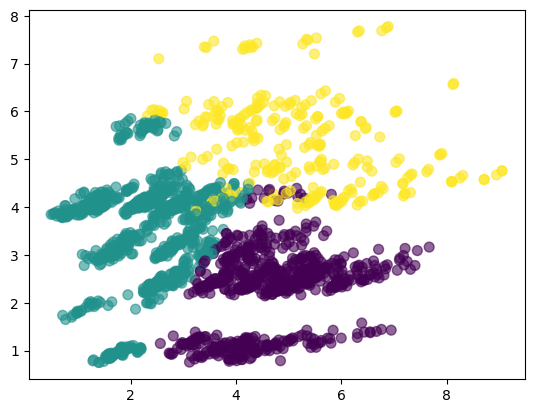

In [1]:
path = r"/home/mb/college/bda/BDA/datasets/segmentation data.csv"

from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler, VectorAssembler, PCA, StringIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator

spark = SparkSession.builder.appName("Iris Multivariate Analysis").getOrCreate()

df = spark.read.csv(path, header=True, inferSchema=True)

# df.show()

df_cols = ['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']

# print(df_cols)

assembler = VectorAssembler(inputCols=df_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled")
pca = PCA(inputCol="scaled", outputCol="pca_features", k=3)
kmeans = KMeans(featuresCol="pca_features", k=3)

pipeline = Pipeline(stages=[assembler, scaler, pca, kmeans])

model = pipeline.fit(df).transform(df)

model.show(truncate=False)


evaluator = ClusteringEvaluator(featuresCol='pca_features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(model)

print(f"Silhouette Score = {silhouette:.4f}")

import matplotlib.pyplot as plt
import pandas as pd

pca_plot = model.select(["pca_features","prediction"]).toPandas()
pca_plot['PC1']= pca_plot["pca_features"].apply(lambda x:x[0])
pca_plot["PC2"] = pca_plot["pca_features"].apply(lambda x:x[1])
plt.scatter(pca_plot['PC1'], pca_plot['PC2'], c=pca_plot['prediction'], cmap='viridis', s=50, alpha=0.6)
plt.show()

spark.stop()